# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [197]:
# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

Solving environment: done

# All requested packages already installed.

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [198]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [199]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [200]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

# pd.read_csv('zoo.csv', delimiter = ',')
you can convert raw file into csv in this way

In [201]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [202]:
your_name = "Coral" # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [203]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [204]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
1054,27,female,23.83170,0,no,3822.956142
96,54,female,34.18800,3,no,13800.064800
1281,47,female,30.68595,2,yes,27970.696347
103,61,female,33.21120,3,yes,35274.098652
1252,20,male,30.30300,0,yes,18505.445580


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [205]:
dataframe

,age,sex,bmi,children,smoker,charges
1054,27,female,23.83170,0,no,3822.956142
96,54,female,34.18800,3,no,13800.064800
1281,47,female,30.68595,2,yes,27970.696347
103,61,female,33.21120,3,yes,35274.098652
1252,20,male,30.30300,0,yes,18505.445580
...,...,...,...,...,...,...
668,62,male,35.53665,0,yes,52109.636949
23,34,female,35.43120,1,yes,42980.139552
410,19,male,19.40280,0,no,1848.327828
8,37,male,33.11130,2,no,7303.308198


In [206]:
num_rows = dataframe.age.size
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [207]:
num_cols = dataframe.columns.size
print(num_cols)

6


# **** Here we define input_cols, output_cols, categorical_cols************

**Q: What are the column titles of the input variables?**

In [208]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker', 'charges']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [209]:
categorical_cols = ['sex', 'smoker']

**Q: What are the column titles of output/target variable(s)?**

In [210]:
output_cols = ['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

min 1278.9362460000002
max 72698.2879314
avg 15176.124146456692


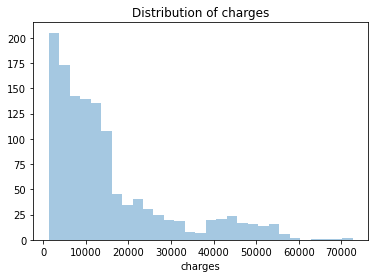

In [211]:
# Write your answer here
print('min', dataframe.charges.min())
print('max', dataframe.charges.max())
print('avg', dataframe.charges.mean())

import seaborn as sns
plt.title('Distribution of charges')
sns.distplot(dataframe.charges, kde = False)

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [212]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "khinthandarkyaw98/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression


'https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays.** If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays**.

 DataFrame.copy(self: ~FrameOrSeries, deep: bool = True) → ~FrameOrSeries[source]

    Make a copy of this object’s indices and data.

    When deep=True (default), a new object will be created with a copy of the calling object’s data and indices. Modifications to the data or indices of the copy will not be reflected in the original object (see notes below).

    When deep=False, a new object will be created without copying the calling object’s data or index (only references to the data and index are copied). Any changes to the data of the original will be reflected in the shallow copy (and vice versa).

In [213]:
dataframe

,age,sex,bmi,children,smoker,charges
1054,27,female,23.83170,0,no,3822.956142
96,54,female,34.18800,3,no,13800.064800
1281,47,female,30.68595,2,yes,27970.696347
103,61,female,33.21120,3,yes,35274.098652
1252,20,male,30.30300,0,yes,18505.445580
...,...,...,...,...,...,...
668,62,male,35.53665,0,yes,52109.636949
23,34,female,35.43120,1,yes,42980.139552
410,19,male,19.40280,0,no,1848.327828
8,37,male,33.11130,2,no,7303.308198


**To convert categorical_cols into tensor, You need to convert them into numbers first**

In [214]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols: # categorical_cols == non_numeric_cols
        dataframe1[col] = dataframe1[col].astype('category').cat.codes # takes cols in alphabetical order
        # cat.codes is like converting your non-numeric col values into integer ( like one hot-coding???)
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

*testing*

In [215]:
dataframe[input_cols]

,age,sex,bmi,children,smoker,charges
1054,27,female,23.83170,0,no,3822.956142
96,54,female,34.18800,3,no,13800.064800
1281,47,female,30.68595,2,yes,27970.696347
103,61,female,33.21120,3,yes,35274.098652
1252,20,male,30.30300,0,yes,18505.445580
...,...,...,...,...,...,...
668,62,male,35.53665,0,yes,52109.636949
23,34,female,35.43120,1,yes,42980.139552
410,19,male,19.40280,0,no,1848.327828
8,37,male,33.11130,2,no,7303.308198


*testing*

In [216]:
print(dataframe[output_cols])
print(dataframe[output_cols].to_numpy)

           charges
1054   3822.956142
96    13800.064800
1281  27970.696347
103   35274.098652
1252  18505.445580
...            ...
668   52109.636949
23    42980.139552
410    1848.327828
8      7303.308198
655   28120.857660

[1271 rows x 1 columns]
<bound method DataFrame.to_numpy of            charges
1054   3822.956142
96    13800.064800
1281  27970.696347
103   35274.098652
1252  18505.445580
...            ...
668   52109.636949
23    42980.139552
410    1848.327828
8      7303.308198
655   28120.857660

[1271 rows x 1 columns]>


testing

In [217]:
dataframe

,age,sex,bmi,children,smoker,charges
1054,27,female,23.83170,0,no,3822.956142
96,54,female,34.18800,3,no,13800.064800
1281,47,female,30.68595,2,yes,27970.696347
103,61,female,33.21120,3,yes,35274.098652
1252,20,male,30.30300,0,yes,18505.445580
...,...,...,...,...,...,...
668,62,male,35.53665,0,yes,52109.636949
23,34,female,35.43120,1,yes,42980.139552
410,19,male,19.40280,0,no,1848.327828
8,37,male,33.11130,2,no,7303.308198


In [218]:
inputs_array, targets_array = dataframe_to_arrays(dataframe) # convert input_cols, output_cols(targets) into array
inputs_array, targets_array

(array([[2.70000000e+01, 0.00000000e+00, 2.38317000e+01, 0.00000000e+00,
         0.00000000e+00, 3.82295614e+03],
        [5.40000000e+01, 0.00000000e+00, 3.41880000e+01, 3.00000000e+00,
         0.00000000e+00, 1.38000648e+04],
        [4.70000000e+01, 0.00000000e+00, 3.06859500e+01, 2.00000000e+00,
         1.00000000e+00, 2.79706963e+04],
        ...,
        [1.90000000e+01, 1.00000000e+00, 1.94028000e+01, 0.00000000e+00,
         0.00000000e+00, 1.84832783e+03],
        [3.70000000e+01, 1.00000000e+00, 3.31113000e+01, 2.00000000e+00,
         0.00000000e+00, 7.30330820e+03],
        [5.20000000e+01, 0.00000000e+00, 2.80830000e+01, 2.00000000e+00,
         1.00000000e+00, 2.81208577e+04]]),
 array([[ 3822.956142],
        [13800.0648  ],
        [27970.696347],
        ...,
        [ 1848.327828],
        [ 7303.308198],
        [28120.85766 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [219]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)
inputs, targets

(tensor([[2.7000e+01, 0.0000e+00, 2.3832e+01, 0.0000e+00, 0.0000e+00, 3.8230e+03],
         [5.4000e+01, 0.0000e+00, 3.4188e+01, 3.0000e+00, 0.0000e+00, 1.3800e+04],
         [4.7000e+01, 0.0000e+00, 3.0686e+01, 2.0000e+00, 1.0000e+00, 2.7971e+04],
         ...,
         [1.9000e+01, 1.0000e+00, 1.9403e+01, 0.0000e+00, 0.0000e+00, 1.8483e+03],
         [3.7000e+01, 1.0000e+00, 3.3111e+01, 2.0000e+00, 0.0000e+00, 7.3033e+03],
         [5.2000e+01, 0.0000e+00, 2.8083e+01, 2.0000e+00, 1.0000e+00, 2.8121e+04]]),
 tensor([[ 3822.9561],
         [13800.0645],
         [27970.6973],
         ...,
         [ 1848.3279],
         [ 7303.3081],
         [28120.8574]]))

In [220]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [221]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [222]:
val_percent = 0.1 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [val_size, train_size])
# split the dataset by using size
# Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [223]:
batch_size = 32

In [224]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
# need to shuffle the train_ds for better result
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [225]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[3.0000e+01, 0.0000e+00, 3.0747e+01, 0.0000e+00, 0.0000e+00, 4.0518e+03],
        [5.6000e+01, 0.0000e+00, 3.1424e+01, 0.0000e+00, 0.0000e+00, 1.3290e+04],
        [3.7000e+01, 0.0000e+00, 2.9304e+01, 0.0000e+00, 1.0000e+00, 2.2275e+04],
        [6.3000e+01, 1.0000e+00, 4.4178e+01, 3.0000e+00, 0.0000e+00, 1.7294e+04],
        [2.7000e+01, 1.0000e+00, 2.0985e+01, 3.0000e+00, 0.0000e+00, 5.5038e+03],
        [2.6000e+01, 0.0000e+00, 3.2900e+01, 4.0000e+00, 0.0000e+00, 2.8126e+04],
        [2.9000e+01, 1.0000e+00, 3.8184e+01, 0.0000e+00, 1.0000e+00, 4.1265e+04],
        [3.6000e+01, 0.0000e+00, 2.5086e+01, 2.0000e+00, 1.0000e+00, 2.1213e+04],
        [4.8000e+01, 0.0000e+00, 3.9860e+01, 1.0000e+00, 0.0000e+00, 3.0087e+04],
        [1.8000e+01, 0.0000e+00, 3.5431e+01, 0.0000e+00, 0.0000e+00, 2.5148e+03],
        [5.6000e+01, 0.0000e+00, 3.7540e+01, 2.0000e+00, 0.0000e+00, 1.4413e+04],
        [5.8000e+01, 0.0000e+00, 4.6520e+01, 0.0000e+00, 0.0000e+00, 2.7619e+04],
        

Let's save our work by committing to Jovian.

In [226]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "khinthandarkyaw98/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression


'https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [227]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

Forward selections is a type of stepwise regression which begins with an empty model and adds in variables one by one. In each forward step, you add the one variable that gives the single best improvement to your model.

tensor.detach() creates a tensor that shares storage with tensor that does not require grad. It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.

L1 Loss Function is used to minimize the error which is the sum of the all the absolute differences between the true value and the predicted value.
I tried with mse.  I got nan values. So I used L1.

In [228]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size) # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out,targets)                      # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out,targets)                          # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [229]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [230]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0383, -0.3357,  0.0089, -0.3672,  0.1905,  0.2904]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0648], requires_grad=True)]

One final commit before we train the model.

In [231]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "khinthandarkyaw98/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression


'https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [232]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [233]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 10765.265625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [234]:
model = InsuranceModel()
epochs = 15
lr = 1e-5
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [15], val_loss: 1847.0736


In [235]:
model = InsuranceModel()
epochs = 1000
lr = 1e-5
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 376.3548
Epoch [40], val_loss: 816.7411
Epoch [60], val_loss: 666.6343
Epoch [80], val_loss: 377.5777
Epoch [100], val_loss: 972.0190
Epoch [120], val_loss: 866.6115
Epoch [140], val_loss: 522.3056
Epoch [160], val_loss: 892.6687
Epoch [180], val_loss: 233.1248
Epoch [200], val_loss: 1631.8043
Epoch [220], val_loss: 939.8110
Epoch [240], val_loss: 208.5635
Epoch [260], val_loss: 1873.5424
Epoch [280], val_loss: 405.3205
Epoch [300], val_loss: 252.2981
Epoch [320], val_loss: 2112.5535
Epoch [340], val_loss: 1075.4940
Epoch [360], val_loss: 1454.8195
Epoch [380], val_loss: 2333.0745
Epoch [400], val_loss: 117.7959
Epoch [420], val_loss: 701.8427
Epoch [440], val_loss: 1969.7064
Epoch [460], val_loss: 1528.7529
Epoch [480], val_loss: 2157.3174
Epoch [500], val_loss: 523.8890
Epoch [520], val_loss: 540.7785
Epoch [540], val_loss: 299.5606
Epoch [560], val_loss: 2136.5166
Epoch [580], val_loss: 238.5193
Epoch [600], val_loss: 1449.0999
Epoch [620], val_loss: 2402.9507


In [236]:
model = InsuranceModel()
epochs = 20
lr = 1e-6
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 1012.1033


In [243]:
model = InsuranceModel()
epochs = 500
lr = 1e-6
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 2456.2170
Epoch [40], val_loss: 153.0381
Epoch [60], val_loss: 46.1781
Epoch [80], val_loss: 53.3791
Epoch [100], val_loss: 148.7442
Epoch [120], val_loss: 118.8286
Epoch [140], val_loss: 201.0592
Epoch [160], val_loss: 176.8252
Epoch [180], val_loss: 50.5789
Epoch [200], val_loss: 119.2274
Epoch [220], val_loss: 88.3004
Epoch [240], val_loss: 99.4764
Epoch [260], val_loss: 87.7647
Epoch [280], val_loss: 160.6096
Epoch [300], val_loss: 193.6243
Epoch [320], val_loss: 187.2606
Epoch [340], val_loss: 34.0252
Epoch [360], val_loss: 125.2435
Epoch [380], val_loss: 35.5648
Epoch [400], val_loss: 201.6313
Epoch [420], val_loss: 13.2147
Epoch [440], val_loss: 121.1310
Epoch [460], val_loss: 142.2651
Epoch [480], val_loss: 127.5317
Epoch [500], val_loss: 187.7902


In [238]:
model = InsuranceModel()
epochs = 1000
lr = 1e-5
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 1023.6700
Epoch [40], val_loss: 1021.8723
Epoch [60], val_loss: 766.1937
Epoch [80], val_loss: 2226.0813
Epoch [100], val_loss: 768.7686
Epoch [120], val_loss: 247.0758
Epoch [140], val_loss: 904.2988
Epoch [160], val_loss: 104.3275
Epoch [180], val_loss: 684.5402
Epoch [200], val_loss: 358.8829
Epoch [220], val_loss: 2291.2493
Epoch [240], val_loss: 376.5434
Epoch [260], val_loss: 833.3893
Epoch [280], val_loss: 205.3167
Epoch [300], val_loss: 625.9207
Epoch [320], val_loss: 1749.5679
Epoch [340], val_loss: 854.1062
Epoch [360], val_loss: 28.3702
Epoch [380], val_loss: 1438.9299
Epoch [400], val_loss: 2062.0303
Epoch [420], val_loss: 666.7927
Epoch [440], val_loss: 1799.2916
Epoch [460], val_loss: 754.1644
Epoch [480], val_loss: 1469.3892
Epoch [500], val_loss: 1104.1407
Epoch [520], val_loss: 1753.8624
Epoch [540], val_loss: 95.8531
Epoch [560], val_loss: 554.9839
Epoch [580], val_loss: 752.0250
Epoch [600], val_loss: 1342.7739
Epoch [620], val_loss: 2409.7217
E

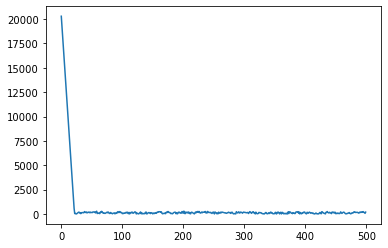

In [244]:
loss = []
for values in history4:
    loss.append(values['val_loss'])
plt.plot(loss)

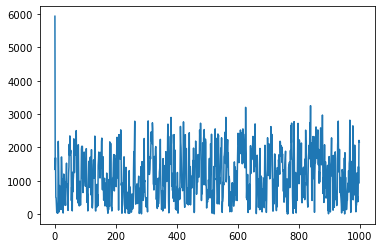

In [242]:
loss = []
for values in history2:
    loss.append(values['val_loss'])
plt.plot(loss)

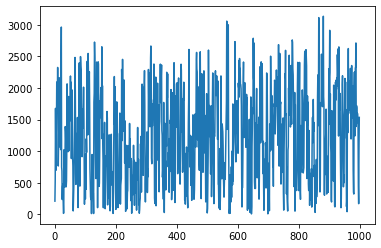

In [241]:
loss = []
for values in history5:
    loss.append(values['val_loss'])
plt.plot(loss)

**Q: What is the final validation loss of your model?**

In [245]:
val_loss = 1533.3641

Let's log the final validation loss to Jovian and commit the notebook

In [246]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [247]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "khinthandarkyaw98/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression


'https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [248]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)              # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [249]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([3.7000e+01, 0.0000e+00, 3.2745e+01, 2.0000e+00, 0.0000e+00, 7.1956e+03])
Target: tensor([7195.6255])
Prediction: tensor([7279.7412])


In [250]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([  25.0000,    0.0000,   38.2784,    0.0000,    0.0000, 3444.8625])
Target: tensor([3444.8625])
Prediction: tensor([3479.9390])


In [251]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([  25.0000,    0.0000,   31.7404,    0.0000,    0.0000, 3663.5291])
Target: tensor([3663.5291])
Prediction: tensor([3702.9651])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [ ]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "khinthandarkyaw98/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
